In [ ]:
#1.Importing packages 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import scipy.integrate as integrate

In [6]:
#2.Parameters
beta= 0.7
rho = 0.4
mu = 1/(1+0.02)
sigma = 0.6
#number of shocks
nu_shocks = 5
eps = np.random.normal(0.5, sigma, size=(nu_shocks))


In [7]:
# 3.computing R_t
R = np.empty(nu_shocks)
R[0] = 0.0 + eps[0]
for t in range(1, nu_shocks):
    R[t] = rho * R[t - 1] + (1 - rho) * mu + eps[t]

In [8]:
# 4.creating grid point for shocks
import ar1_approx as ar
ln_R_grid, pi_t =ar.addacooper(nu_shocks, mu, rho, sigma)
R_grid = np.exp(ln_R_grid)
pi = np.transpose(pi_t)

In [62]:
#5.Creating grid for state space
'''
lowerB_i     = scalar, lower bound of investment grid
UpperB_i      = scalar, upper bound of investment grid 
NG_i    = integer, number of grid points 
I_g    = vector, NG_i x 1 vector of grid points 

'''
lowerB_i = 0.0 #Lower bound for Investment
UpperB_i = 8.0 #Upper bound for Investment
NG_i = 500  # Number of grid points
I_g = np.linspace(lowerB_i,UpperB_i, NG_i)

In [11]:
# 6. Creating grid for current utility values
'''
C = matrix for current consumption (c=Ri-i')
U = matrix for period t utility value 

'''
C = np.zeros((nu_shocks, NG_i, NG_i)) 
for e in range(nu_shocks):
    for i in range(NG_i): 
        for k in range(NG_i):
            C[e,i,k] = R_grid[e] * I_g[i]-I_g[k]

C[C<=0] = 1e-15 # non-negative constraint for consumption
if (C == 0).any() :
      U = 0
else:
    U = np.log(C)
  
U[C<0] = -9999999

In [12]:
# 7.Value Function Iteration 
'''
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = matrix, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of i and i'and R
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of i' for all i and R
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-15 
VFdist = 5.0 
VFmaxiter = 500 
V = np.zeros((nu_shocks, NG_i) ) 
Vmat = np.zeros((nu_shocks,NG_i, NG_i )) 
Vstore = np.zeros((nu_shocks, NG_i, VFmaxiter)) 
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(nu_shocks): 
        for j in range(NG_i): 
                EV = 0
                for ii in range(nu_shocks): 
                    EV += pi[i, ii] * V[ii, max(j - 1, 0)]   
                Vmat[i, j] = U[i, j] + beta * EV   
    Vstore[:, VFiter] = V.reshape((nu_shocks,NG_i)) 
    TV = Vmat.max(1) 
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  
    V = TV
    VFiter += 1 
    
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            
# solution to the functional equation
VF = V 

Value function converged after this many iterations: 105


<Figure size 432x288 with 0 Axes>

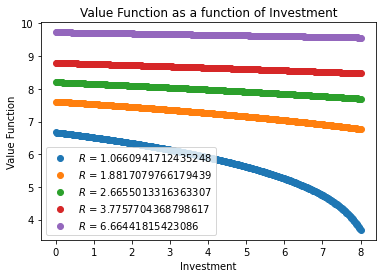

In [14]:
# 8.Visualization, value function 
plt.figure()
fig, ax = plt.subplots()
plt.scatter(I_g[1:], VF[0,1:], label='$R$ = ' + str(R_grid[0]))
plt.scatter(I_g[1:], VF[1,1:], label='$R$ = ' + str(R_grid[1]))
plt.scatter(I_g[1:], VF[2,1:], label='$R$ = ' + str(R_grid[2]))
plt.scatter(I_g[1:], VF[3,1:], label='$R$ = ' + str(R_grid[3]))
plt.scatter(I_g[1:], VF[4,1:], label='$R$ = ' + str(R_grid[4]))
legend = ax.legend(loc='lower left', shadow=False)
plt.xlabel('Investment')
plt.ylabel('Value Function')
plt.title('Value Function as a function of Investment')
plt.show()

<Figure size 432x288 with 0 Axes>

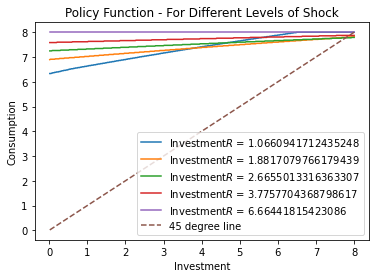

In [69]:
# 9.Policy function visualization
opt_i_0 = I_g[PF[0]] # tomorrow's optimal Investment
opt_i_1 = I_g[PF[1]] 
opt_i_2 = I_g[PF[2]] 
opt_i_3 = I_g[PF[3]] 
opt_i_4 = I_g[PF[4]] 

optC_0 =I_g - opt_i_0 # optimal consumption 
optC_1 =I_g - opt_i_1
optC_2 =I_g - opt_i_2
optC_3 =I_g - opt_i_3
optC_4 =I_g - opt_i_4

plt.figure()
fig, ax = plt.subplots()
ax.plot(I_g[1:], opt_i_0[1:], label='Investment'+'$R$ = ' + str(R_grid[0]))
ax.plot(I_g[1:], opt_i_1[1:], label='Investment'+'$R$ = ' + str(R_grid[1]))
ax.plot(I_g[1:], opt_i_2[1:], label='Investment''$R$ = ' + str(R_grid[2]))
ax.plot(I_g[1:], opt_i_3[1:], label='Investment'+'$R$ = ' + str(R_grid[3]))
ax.plot(I_g[1:], opt_i_4[1:], label='Investment'+'$R$ = ' + str(R_grid[4]))

ax.plot(I_g[1:], I_g[1:], '--', label='45 degree line')
legend = ax.legend(loc='lower right', shadow=False)
plt.xlabel('Investment')
plt.ylabel('Consumption')
plt.title('Policy Function - For Different Levels of Shock')
plt.show()